In [1]:
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

import pandas as pd

In [2]:
seaborn.set()

In [3]:
tf.config.set_visible_devices([], 'GPU')


In [4]:
import quandl

In [5]:
from filterflow.smc import SMC
from filterflow.base import State, StateSeries, DTYPE_TO_STATE_SERIES

from filterflow.observation.base import ObservationModelBase, ObservationSampler
from filterflow.observation.linear import LinearObservationSampler
from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform, PartiallyCorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import RicattiSolver

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

## Process data

In [6]:
quandl.ApiConfig.api_key = 'jZW1PtowF5LAjWcJ3yiU'

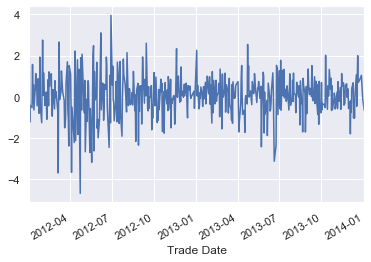

In [7]:
d =  quandl.get("NASDAQOMX/OMXS30", start_date="2012-01-02", end_date="2014-01-02")
y = np.log(d['Index Value']).diff()[1:] * 100
y.plot()

References:
- [Towards Smooth Particle Filters for
Likelihood Estimation with
Multivariate Latent Variables
](https://www.cs.ubc.ca/grads/resources/thesis/Nov08/Lee_Anthony.pdf)

Basic Model

$y_t \sim \mathcal{N}(\mathbf{B}\mathbf{f}_t, \mathbf{\Psi})$

$\mathbf{f}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{H}_t)$

$\mathbf{\alpha}_t \sim \mathcal{N}(\mathbf{\Phi}\mathbf{\alpha}_{t-1}, \mathbf{U})$

$\mathbf{\Psi} = \text{diag}(\psi_1, \ldots, \psi_M)$

$\mathbf{H}_t = \text{diag}(\exp(\mathbf{\alpha}_t))$

$\mathbf{\Phi} = \text{diag}(\phi_1, \ldots, \phi_M)$

For identifiability let:

$\mathbf{B} = \begin{bmatrix}
                     1   & 0   & 0   \\
                     0.5 & 1   & 0   \\
                     0.5 & 0.5 & 1   \\
                     0.2 & 0.6 & 0.3 \\
                     0.8 & 0.7 & 0.5
                \end{bmatrix}
$
$\hspace{2cm}$ 
$\mathbf{U} = \begin{bmatrix}
                    0.5 & 0.2 & 0.1 \\
                    0.2 & 0.5 & 0.2 \\
                    0.1 & 0.2 & 0.5
\end{bmatrix}$

In [8]:
K = 3
M = 5
T = 100

In [9]:
# Variables to train
B_init = np.array([[1., 0., 0,], 
                  [0.5, 1., 0.],
                  [0.5, 0.5, 1.],
                  [0.2, 0.6, 0.3],
                  [0.8, 0.7, 0.5]])

U_init = np.array([[0.5, 0.2, 0.1], 
                  [0.2, 0.5, 0.2],
                  [0.1, 0.2, 0.5]])

phi_init = np.repeat(0.9, K)
psi_init = np.repeat(0.5, M)

In [10]:
Bt = tf.constant(B_init, dtype=float)
Ut = tf.constant(U_init, dtype=float)
phit = tf.constant(phi_init, dtype=float)
psit = tf.constant(psi_init, dtype=float)

## Transition

In [11]:
zeros_k = tf.zeros(K, dtype=float)
chol_transition_cov = tf.linalg.cholesky(Ut)
transition_noise = tfp.distributions.MultivariateNormalTriL(zeros_k, chol_transition_cov)
transition_matrix = tf.linalg.diag(phit)
transition_model = RandomWalkModel(transition_matrix, transition_noise)

B = Bt
psi = psit


## Observation Model

In [12]:
zeros_m = tf.zeros(M, dtype=float)


class SVObservationModel(ObservationSampler):
    def __init__(self, B, Psi, name='SVObservationModel'):
        self.B = B
        self.Psi = Psi
        self.M = B.shape[0]
        super(ObservationSampler, self).__init__(name=name)

    
    def generate_dist(self, state):
        alpha = tf.clip_by_value(state.particles, -10., 10.)
        e_alpha_2 = tf.exp(alpha/2.)
        e_alpha_2 = tf.reshape(e_alpha_2, [state.batch_size, state.n_particles, 1, state.dimension])
        B_tilde = tf.reshape(self.B, [1, 1, self.B.shape[0], self.B.shape[1]]) * e_alpha_2
        # no need for expliciting the diagonal matrix - this is more efficient
        Cov = tf.linalg.matmul(B_tilde, B_tilde, transpose_b=True)
        Cov = Cov + self.Psi
        cov_chol = tf.linalg.cholesky(Cov)
        obs_dist = tfp.distributions.MultivariateNormalTriL(tf.zeros(self.M, dtype=float), cov_chol)
        
        return obs_dist

    def loglikelihood(self, state: State, observation: tf.Tensor):
        """Computes the loglikelihood of an observation given proposed particles
        :param state: State
            Proposed (predicted) state of the filter given State at t-1 and Observation
        :param observation: ObservationBase
            User/Process given observation
        :return: a tensor of loglikelihoods for all particles
        :rtype: tf.Tensor
        """
        
        obs_dist = self.generate_dist(state)
        log_prob = obs_dist.log_prob(observation)
        return tf.reshape(log_prob, [batch_size, n_particles])

    def sample(self, state: State):
        """Samples a new observation conditionally on latent state
        :param state: State
            State of the filter at t
        :return: observartion 
        :rtype: Observation
        """
        
        obs_dist = self.generate_dist(state)
        observation = obs_dist.sample()
        
        return observation
        

In [13]:
observation_model = SVObservationModel(Bt, tf.linalg.diag(psi))

## State Space Model

In [14]:
initial_value = zeros_k
ss_model = StateSpaceModel(observation_model=observation_model, transition_model=transition_model)
states, observations = ss_model(initial_value, T)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


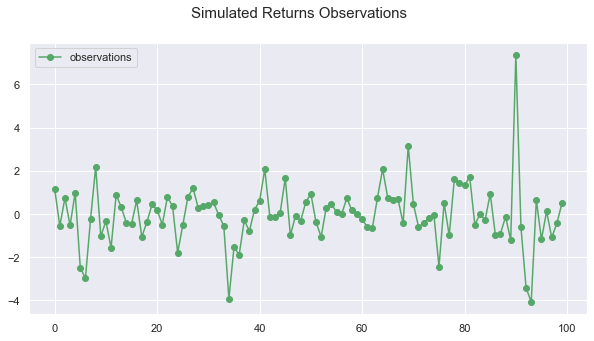

In [15]:
np_obs = observations.numpy().squeeze()
np_states = states.numpy().squeeze()

linspace  = np.arange(T)
fig, axes = plt.subplots(nrows=1, figsize=(10, 5))
axes.plot(linspace, np_obs[:,0], marker='o', color='g', label='observations')
_ = axes.legend(loc='upper left')
_ = fig.suptitle('Simulated Returns Observations', fontsize=15)

In [16]:
obs_data = tf.data.Dataset.from_tensor_slices(observations)

## Particle Filter

In [17]:
# store observations
batch_size = 1
n_particles = 100
dimension = K

In [18]:
# initial state
normal_dist = tfp.distributions.Normal(0., 1.)
initial_particles = tf.zeros([batch_size, n_particles, dimension])

initial_particles = tf.cast(initial_particles, dtype=float)

initial_weights = tf.ones((batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
log_likelihoods = tf.zeros(batch_size, dtype=float)
initial_state = State(particles=initial_particles, 
                      log_weights = tf.math.log(initial_weights),
                      weights=initial_weights, 
                      log_likelihoods=log_likelihoods, 
                      ancestor_indices=None,
                      resampling_correction=None)

# proposal
proposal_model = BootstrapProposalModel(transition_model)

In [19]:
# resampling
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
systematic = SystematicResampler()
multinomial = MultinomialResampler()


epsilon = tf.constant(0.25)
scaling = tf.constant(0.33)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-1)

In [20]:
particle_filter = SMC(observation_model, transition_model, proposal_model, resampling_criterion, regularized)

recorded_states = particle_filter(initial_state, observation_series=obs_data, n_observations=T)

recorded_states  = attr.evolve(recorded_states)

ht = np_states

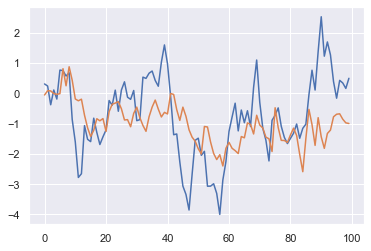

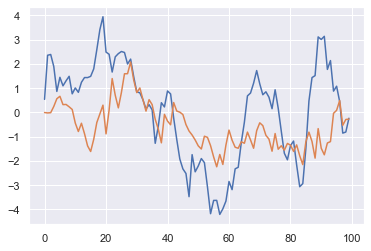

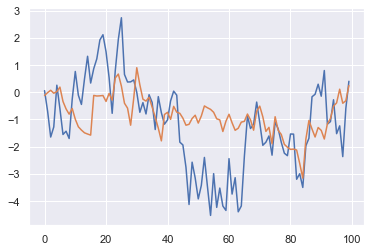

In [21]:
for i in range(K):
    
    # compute states
    computed_states = []
    for t, observation in enumerate(observations):
        state = recorded_states.read(tf.constant(t, dtype=tf.int32))
        log_weights = state.log_weights.numpy()
        particles = state.particles.numpy()[:,:,i]
        weights = np.exp(log_weights)
        computed_state = np.sum((weights * particles), axis=1)
        computed_states.append(computed_state)

    computed_states = np.array(computed_states).flatten()

    plt.plot(ht[:,i])
    plt.plot(computed_states)
    plt.show()

## Learn Param

In [22]:
# store observations
batch_size = 10
n_particles = 4
dimension = K

In [23]:
# initial state
normal_dist = tfp.distributions.Normal(0., 2.)
initial_particles = normal_dist.sample([batch_size, n_particles, dimension])

initial_particles = tf.cast(initial_particles, dtype=float)

initial_weights = tf.ones((batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
log_likelihoods = tf.zeros(batch_size, dtype=float)
initial_state = State(particles=initial_particles, 
                      log_weights = tf.math.log(initial_weights),
                      weights=initial_weights, 
                      log_likelihoods=log_likelihoods, 
                      ancestor_indices=None, 
                      resampling_correction=None)

In [24]:
# large state
large_batch_size = 50
large_initial_particles = normal_dist.sample([batch_size, n_particles, dimension])

large_initial_particles = tf.cast(large_initial_particles, dtype=float)

large_initial_weights = tf.ones((large_batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
large_log_likelihoods = tf.zeros(large_batch_size, dtype=float)
large_initial_state = State(particles=large_initial_particles, 
                      log_weights = tf.math.log(large_initial_weights),
                      weights=large_initial_weights, 
                      log_likelihoods=large_log_likelihoods, 
                      ancestor_indices=None, 
                      resampling_correction=None)

In [25]:
transition_matrix_init = tf.eye(K)
learnable_transition_matrix = tf.Variable(transition_matrix_init, trainable=True)

zeros_k = tf.zeros(K, dtype=float)
chol_transition_cov_init = tf.linalg.cholesky(Ut)
learnable_transition_cov = tf.Variable(chol_transition_cov_init, trainable=True)

transition_noise = tfp.distributions.MultivariateNormalTriL(zeros_k, learnable_transition_cov)
learn_transition_model = RandomWalkModel(learnable_transition_matrix, transition_noise)

# proposal
proposal_model = BootstrapProposalModel(learn_transition_model)

In [26]:
learnable_B = tf.Variable(B, trainable=True)
psi_init = tf.constant(0.)
learnable_psi = tf.Variable(psi_init, trainable=True)

learnable_observation_model = SVObservationModel(learnable_B, tf.eye(M) * tf.math.exp(learnable_psi))

In [27]:
trainable_variables = [learnable_transition_matrix, 
                       learnable_transition_cov, 
                       learnable_B, 
                       learnable_psi]

init_values = [transition_matrix_init, chol_transition_cov_init, B, psi_init]

In [28]:
# resampling
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
systematic = SystematicResampler()
multinomial = MultinomialResampler()


epsilon = tf.constant(0.5)
scaling = tf.constant(0.75)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-2)
partially_corrected = PartiallyCorrectedRegularizedTransform(regularized)

In [29]:
regularized_filter = SMC(learnable_observation_model, learn_transition_model, proposal_model, resampling_criterion, regularized)
partially_corrected_filter = SMC(learnable_observation_model, learn_transition_model, proposal_model, resampling_criterion, partially_corrected)

systematic_filter = SMC(learnable_observation_model, learn_transition_model, proposal_model, resampling_criterion, systematic)

recorded_states = systematic_filter(initial_state, observation_series=obs_data, n_observations=T)
recorded_states  = attr.evolve(recorded_states)


In [30]:
# Create an optimizer.
optimizer = tf.optimizers.Adam(learning_rate=0.001, epsilon=1e-8)


@tf.function
def smc_routine(smc, state, use_correction_term=False):
    final_state = smc(initial_state, 
                      observation_series=obs_data, 
                      n_observations=T, 
                      return_final=True)

    res = tf.reduce_mean(final_state.log_likelihoods)
    if use_correction_term:
        return res, tf.reduce_mean(final_state.resampling_correction)
    return res, tf.constant(0.)
    

@tf.function
def run_one_step(smc, use_correction_term, init_state):
    with tf.GradientTape() as tape:
        tape.watch(trainable_variables)
        real_ll, correction = smc_routine(smc, init_state, use_correction_term)
        loss = -(real_ll + correction)
    grads_loss = tape.gradient(loss, trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    return real_ll, grads_loss


@tf.function
def train_one_step(smc, use_correction_term):
    real_ll, grads_loss = run_one_step(smc, use_correction_term, initial_state)
    clip = lambda x: x # tf.clip_by_value(x, -500., 500.)
    grads_loss = [clip(grad) for grad in grads_loss]
    optimizer.apply_gradients(zip(grads_loss, trainable_variables))
    return -real_ll, grads_loss


@tf.function
def train_niter(smc, num_steps=100, use_correction_term=False, reset=True):
    reset_trainable_variables = [v.assign(init) for v, init in zip(trainable_variables, init_values)]
    if reset:
        reset_operations = reset_trainable_variables
    else:
        reset_operations = []

    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    time_tensor_array = tf.TensorArray(dtype=tf.float64, size=num_steps, dynamic_size=False, element_shape=[])
    with tf.control_dependencies(reset_operations):
        tic = tf.timestamp()
        for step in tf.range(1, num_steps+1):
            loss, grads = train_one_step(smc, use_correction_term)
            elbo, _ = run_one_step(systematic_filter, False, large_initial_state)

            toc = tf.timestamp()
            max_grad = tf.reduce_max([tf.reduce_max(tf.abs(grad)) for grad in grads])
            if True: # step % (num_steps // 100) == 0:
                tf.print('Step', step, '/', num_steps, ': ms per step= ', 1000. * (toc - tic) / tf.cast(step, tf.float64), ': total time (s)= ', (toc - tic), ', loss = ', loss, ', max abs grads = ', max_grad, end='\r')
            loss_tensor_array = loss_tensor_array.write(step-1, -elbo)
            grad_tensor_array = grad_tensor_array.write(step-1, max_grad)
            time_tensor_array = time_tensor_array.write(step-1, toc-tic)
    return loss_tensor_array.stack(), grad_tensor_array.stack(), time_tensor_array.stack()
            
@tf.function
def train_total_time(smc, total_time, use_correction_term=False, reset=True):
    reset_trainable_variables = [v.assign(init) for v, init in zip(trainable_variables, init_values)]

    if reset:
        reset_operations = reset_trainable_variables
    else:
        reset_operations = []
        
    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, element_shape=[])
    time_tensor_array = tf.TensorArray(dtype=tf.float64, size=0, dynamic_size=True, element_shape=[])
    with tf.control_dependencies(reset_operations):
        tic = tf.timestamp()
        toc = tic
        step = tf.constant(1)
        while toc - tic < total_time:
            loss, grads = train_one_step(smc, use_correction_term)
            elbo, _ = run_one_step(systematic_filter, False, large_initial_state)
            max_grad = tf.reduce_max([tf.reduce_max(tf.abs(grad)) for grad in grads])
            loss_tensor_array = loss_tensor_array.write(step-1, -elbo)
            grad_tensor_array = grad_tensor_array.write(step-1, max_grad)
            time_tensor_array = time_tensor_array.write(step-1, toc-tic)
            step = step + 1

            toc = tf.timestamp()

            tf.print('Time elapsed (s): ', toc-tic, ', n_steps: ', step, ': ms per step= ', 1000. * (toc - tic) / tf.cast(step, tf.float64), ', loss = ', loss, ', max abs grads = ', max_grad, end='\r')
    return loss_tensor_array.stack(), grad_tensor_array.stack(), time_tensor_array.stack()


@tf.function
def run_several(smc, n_times, use_correction_term=False):
    loss_array = tf.TensorArray(dtype=tf.float32, size=n_times, dynamic_size=False, element_shape=[])
    grad_array = tf.TensorArray(dtype=tf.float32, size=n_times, dynamic_size=False)
    for i in tf.range(n_times):
        real_ll, grads_loss = run_one_step(smc, use_correction_term, init_state)
        loss_array = loss_array.write(i, real_ll)        
        grad_array = grad_array.write(i, grads_loss)
        tf.print('Step: ', i+1, '/', n_times, end='\r')
    return loss_array.stack(), grad_array.stack()

In [31]:
num_steps = tf.constant(200)
total_time = tf.constant(60, dtype=tf.float64)

In [ ]:
reg_loss, reg_grad, reg_time = train_niter(regularized_filter, num_steps=num_steps)

In [ ]:
reg_loss_time, _, _ = train_total_time(regularized_filter, total_time)

In [ ]:
corrected_loss, corrected_grad, corrected_time = train_niter(partially_corrected_filter, num_steps=num_steps)

In [ ]:
corrected_loss_time, _, _ = train_total_time(partially_corrected_filter, total_time)

In [ ]:
sys_loss, sys_grad, sys_time = train_niter(systematic_filter, num_steps=num_steps)

In [ ]:
sys_loss_time, _, _ = train_total_time(systematic_filter, total_time)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(reg_loss.numpy(), color='green')
ax.plot(corrected_loss.numpy(), color='orange')
ax.plot(sys_loss.numpy(), color='blue')
fig.savefig(os.path.join('./charts/', 'stochvol_loss_per_epoch.png'))


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.linspace(0, total_time.numpy().sum(), len(reg_loss_time.numpy())), reg_loss_time.numpy(), color='green')
ax.plot(np.linspace(0, total_time.numpy().sum(), len(corrected_loss_time.numpy())), corrected_loss_time.numpy(), color='orange')
ax.plot(np.linspace(0, total_time.numpy().sum(), len(sys_loss_time.numpy())), sys_loss_time.numpy(), color='blue')
fig.savefig(os.path.join('./charts/', 'stochvol_loss_per_time.png'))


In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(sys_loss, color='b', alpha=0.5)
ax.plot(reg_loss, color='g', alpha=0.5)
# ax.plot(corrected_loss, color='r', alpha=0.5)

In [ ]:
1